# How to use the models we trained

In [1]:
# !pip install -U opencv-python tabula-py pdfquery

In [1]:
%load_ext autoreload
%autoreload 2

import os, numpy, glob, collections, random, \
    shutil, pandas, time, subprocess, itertools, \
    cv2, tempfile, scipy, pdfquery, lxml.etree, json
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

from PIL import Image
from IPython.display import display, SVG
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%pylab inline

import model
from model import *
from prepare_images_utils import *
from train_test_augment import augment_image_deterministic, WINDOW_SIZE
from make_inout_pairs import get_stroke, convert_svg

import tabula

import warnings
warnings.filterwarnings('ignore')

pandas.set_option('max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


In [2]:
# segmentation_model = load_model('./models/contours.h5', custom_objects=dict(dice_coef_loss=dice_coef_loss))
segmentation_model = load_model('./models/release1.h5', custom_objects=model.__dict__)

In [3]:
# Network outputs:
# (Footer, Header, Body) - hbf
# (Text - Header+Footer, Body) - bt

DENSITY=72
PIXELS_TO_POINTS_FACTOR = 1

def pdf_to_pages(in_file, out_dir, pages=None):
    if pages is None:
        subprocess.check_call(['convert',
                               '-define', 'pdf:use-cropbox=true',
                               in_file,
                               '-density', str(DENSITY),
                               '-resample', '{0}x{0}'.format(DENSITY),
                               os.path.join(out_dir, '%04d.png')])
    else:
        for page in pages:
            subprocess.check_call(['convert',
                                   '-define', 'pdf:use-cropbox=true',
                                   '{}[{}]'.format(in_file, page),
                                   '-density', str(DENSITY),
                                   '-resample', '{0}x{0}'.format(DENSITY),
                                   os.path.join(out_dir, '{:04d}.png'.format(page))])
    result = list(glob.glob(os.path.join(out_dir, '*.png')))
    result.sort()
    return result


def process_page(segm_model, full_image_fname, out_dir, mask_threshold=0.5, min_contour_area=500, read_mode='L', read_proc=identity, take_channels=2):
    transformations = list(augment_image_deterministic(full_image_fname, out_dir,
                                                       scales=[(1, 1)],
                                                       rotations=[0]))
    transformed_images = numpy.expand_dims(read_images_to_tensor([f for _, _, _, _, _, f in transformations],
                                                                 mode=read_mode,
                                                                 proc=read_proc),
                                           -1)

    partial_masks = segm_model.predict(transformed_images)
    if isinstance(partial_masks, list):
        partial_masks = partial_masks[0]

    page_image = Image.open(full_image_fname).convert('RGB').convert('L')
#     print('page size', page_image.size)

    aggregated_mask = numpy.zeros((page_image.size[1], page_image.size[0], partial_masks.shape[-1]),
                                  dtype='float32')
    norm = numpy.zeros_like(aggregated_mask)
    for (scale_x, scale_y, x_off, y_off, angle, _), mask_pixels in zip(transformations, partial_masks):
        mask_width = min(WINDOW_SIZE[0], aggregated_mask.shape[1] - x_off)
        mask_height = min(WINDOW_SIZE[1], aggregated_mask.shape[0] - y_off)

        mask = arr_to_img(mask_pixels)
        mask = mask.rotate(-angle).resize((mask_width, mask_height), Image.BILINEAR)
        mask_pixels = numpy.array(mask)
        aggregated_mask[y_off:y_off+mask_pixels.shape[1],
                        x_off:x_off+mask_pixels.shape[0]] += mask_pixels

        norm[y_off:y_off+mask_pixels.shape[1],
             x_off:x_off+mask_pixels.shape[0], :] += 1
    aggregated_mask = numpy.nan_to_num(aggregated_mask / norm) / 255
    nan_mask = numpy.where(aggregated_mask.sum(-1) < 1e-3)
    aggregated_mask[nan_mask[0], nan_mask[1], -1] = 1

#     display(arr_to_img(aggregated_mask))

    # renormalize with softmax
    aggregated_mask = numpy.exp(aggregated_mask)
    aggregated_mask /= numpy.expand_dims(aggregated_mask.sum(-1), -1)
    
#     display(arr_to_img(aggregated_mask))
    
    # binarize by argmax
    max_idx = aggregated_mask.argmax(axis=-1)
    aggregated_mask_bin = numpy.zeros_like(aggregated_mask)
    for channel in range(aggregated_mask.shape[-1]):
        mask = numpy.where(max_idx == channel)
        aggregated_mask_bin[mask[0], mask[1], channel] = 1
#     display(arr_to_img(aggregated_mask_bin))

#     aggregated_mask = binarize_tensor(aggregated_mask, mask_threshold * 255.0)

    contours = [(channel,
                 cv2.findContours((aggregated_mask_bin[:, :, channel]).astype('uint8'),
                                  cv2.RETR_LIST,
                                  cv2.CHAIN_APPROX_SIMPLE)[1])
                for channel in range(take_channels)]
    result = []
    demo_mask = numpy.zeros(aggregated_mask_bin.shape[:-1] + (3,),
                            dtype='uint8')
    for channel, cur_contours in contours:
        for cnt in cur_contours:
            if cv2.contourArea(cnt) < min_contour_area:
                continue
            x, y, w, h = cv2.boundingRect(cnt)
            result.append((channel, numpy.array([y, x, y+h, x+w]) * PIXELS_TO_POINTS_FACTOR))
            color = [0] * 3
            color[channel] = 255
            cv2.drawContours(demo_mask,
                             [numpy.array([(x, y),
                                            (x + w, y),
                                            (x + w, y + h),
                                            (x, y + h)])],
                             -1,
                             tuple(color),
                             cv2.FILLED)

    demo_mask = arr_to_img(demo_mask.astype('float32') / 255.0)
#     display(Image.blend(page_image.convert('RGB'), demo_mask, 0.5))
    return result


def extract_table_with_tabula(pdf_file, page_no, box):
    return tabula.read_pdf(pdf_file, guess=False, pages=page_no, area=tuple(box))


# CORNDER_COORDS_IDX = [(0, 1), (0, 3), (2, 1), (2, 3)]
# def box_to_corner_coords(box):
#     return [(box[i], box[j]) for i, j in CORNDER_COORDS_IDX]


# def two_box_distance(a, b):
#     point_pairs = itertools.product(box_to_corner_coords(a),
#                                     box_to_corner_coords(b))
#     distances = map(scipy.spatial.distance.euclidean, point_pairs)
#     return min(distances)


def rect_distance(a, b):
    y1, x1, y1b, x1b = a
    y2, x2, y2b, x2b = b
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        return scipy.spatial.distance.euclidean((x1, y1b), (x2b, y2))
    elif left and bottom:
        return scipy.spatial.distance.euclidean((x1, y1), (x2b, y2b))
    elif bottom and right:
        return scipy.spatial.distance.euclidean((x1b, y1), (x2, y2b))
    elif right and top:
        return scipy.spatial.distance.euclidean((x1b, y1b), (x2, y2))
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:             # rectangles intersect
        return 0.


def convert_coords_to_pq(box, cropbox):
    ul_y, ul_x, br_y, br_x = box
    x_off, _, _, page_height = cropbox
    return numpy.array([ul_x + x_off, page_height - br_y, br_x + x_off, page_height - ul_y])


def convert_coords_from_pq(box, cropbox):
    bl_x, bl_y, ur_x, ur_y = box
    x_off, _, _, page_height = cropbox
    return numpy.array([page_height - ur_y, bl_x - x_off, page_height - bl_y, ur_x - x_off])


TableInfo = collections.namedtuple('TableInfo',
                                   'page surrounding_text_boxes surrounding_texts body_box body success'.split(' '))


def process_pdf(segm_model, in_file, tmp_dir_prefix='/tmp', return_only_successful=True, pad=2, pages=None, max_text_distance=20, min_table_cols=2, min_table_rows=2):
    result = []
    parsed_pdf = pdfquery.PDFQuery(in_file, parse_tree_cacher=pdfquery.cache.FileCache("/tmp/"), laparams=None)
    parsed_pdf.load()
    with tempfile.TemporaryDirectory(dir=tmp_dir_prefix) as wd:
        page_filenames = pdf_to_pages(in_file, wd, pages=pages)

        for page_fname in page_filenames:
            page_i = int(os.path.splitext(os.path.basename(page_fname))[0])
            page = parsed_pdf.get_page(page_i)
#             print('id', page_i, page.pageid)
#             page_crop = page.cropbox
#             offsets = numpy.array([-page_crop[1] - pad, -page_crop[0] - pad, -page_crop[1] + pad, -page_crop[0] + pad])
            offsets = numpy.array([-pad, -pad, pad, pad])

            boxes = process_page(segm_model, page_fname, wd, mask_threshold=0.5)

            this_page_result = []

            bodies = [box + offsets for channel, box in boxes if channel == 1]
            for body_box in bodies:
                body = extract_table_with_tabula(in_file, page_i + 1, body_box)
                table_info = TableInfo(page_i,
                                       [],
                                       [],
                                       body_box,
                                       body,
                                       (not body is None) and body.shape[0] >= min_table_rows and body.shape[1] >= min_table_cols)
                if table_info.success or not return_only_successful:
                    this_page_result.append(table_info)

#                 if table_info.success:
#                     display(body)

            if len(this_page_result) > 0:
                surrounding_texts = [box + offsets for channel, box in boxes if channel == 0]
                for text_box in surrounding_texts:
#                     print('src box', text_box)
#                     print('src conv', convert_coords_to_pq(text_box, page.cropbox))
                    text_query = 'LTPage[pageid="{}"] :in_bbox("{},{},{},{}")'.format(page_i + 1,
                                                                                      *convert_coords_to_pq(text_box,
                                                                                                            page.cropbox))
#                     print(text_query)
                    query_res = parsed_pdf.pq(text_query)
                    text = query_res.text()
                    if not text:
                        continue
#                     print('found box', query_res[0].layout.bbox)
#                     print('conv back', convert_coords_from_pq(query_res[0].layout.bbox, page.cropbox))
#                     print('cropbox', page.cropbox)
#                     print(text)
                    distances_to_tables = [rect_distance(text_box, table.body_box)
                                           for table in this_page_result]
                    closest = numpy.argmin(distances_to_tables)
                    if distances_to_tables[closest] < max_text_distance:
                        table = this_page_result[closest]
                        table.surrounding_text_boxes.append(text_box)
                        table.surrounding_texts.append(text)

            result.extend(this_page_result)
    return result


def process_pdfs(model, files, *args, **kwargs):
    result = {}
    for file in files:
        result[file] = process_pdf(model, file, *args, **kwargs)
    return result

## Vis

In [4]:
# %%prun -s cumulative
# process_pdfs(segmentation_model, glob.glob('/notebook/data/tmp/*.pdf'))

## Vis2

In [5]:
# Image.fromarray(numpy.squeeze(visualize_activation(segmentation_model, 31)))

In [6]:
# for i, layer in enumerate(segmentation_model.layers):
#     print(i, layer)

# Evaluate

In [4]:
def rect_color_to_class(color):
    color = color.lower()
    if color in ('ff0000', '00ff00'):
        return 'surrounding_text'
    else:
        return 'body'


def get_svg_rectangles(svg_file):
    rects_by_class = collections.defaultdict(list)
    with open(svg_file, 'r') as f:
        tree = lxml.etree.parse(f)
        for n in list(tree.getroot().getchildren()):
            if n.tag.endswith('rect'):
                style = n.get('style') or ''
                stroke = get_stroke(style)
                x = float(n.get('x'))
                y = float(n.get('y'))
                w = float(n.get('width'))
                h = float(n.get('height'))
                rects_by_class[rect_color_to_class(get_stroke(n.get('style') or ''))].append(numpy.array([y, x, y+h, x+w]))
    return rects_by_class


def rect_area(rect):
    y1, x1, y2, x2 = rect
    return (y2 - y1) * (x2 - x1)


def rect_intersection(a, b):
    ay1, ax1, ay2, ax2 = a
    by1, bx1, by2, bx2 = b
    iy1 = max(ay1, by1)
    ix1 = max(ax1, bx1)
    iy2 = min(ay2, by2)
    ix2 = min(ax2, bx2)
    if ix2 - ix1 <= 0 or iy2 - iy1 <= 0:
        return None
    return numpy.array([iy1, ix1, iy2, ix2])


def rect_union(a, b):
    ay1, ax1, ay2, ax2 = a
    by1, bx1, by2, bx2 = b
    return numpy.array([min(ay1, by1),
                        min(ax1, bx1),
                        max(ay2, by2),
                        max(ax2, bx2)])


def rect_dice(a, b):
    intersect = rect_intersection(a, b)
    if not intersect is None:
        return rect_area(intersect) / rect_area(rect_union(a, b))
    else:
        return 0


def calc_page_stat(gold_rects, found_rects, min_tp_dice=0.1):
    fp = 0
    tp = 0
    sum_tp_dice = 0
    full_dice = 0
    found_gr = set()

    for fr in found_rects:
        best_dice = 0
        best_gr_i = None
        for i, gr in enumerate(gold_rects):
            dice = rect_dice(fr, gr)
            if dice > best_dice:
                best_dice = dice
                best_gr_i = i

        if best_gr_i is None or best_dice < min_tp_dice:
            fp += 1
        else:
            tp += 1
            sum_tp_dice += best_dice
            found_gr.add(best_gr_i)
        full_dice += best_dice

    return dict(found_n=len(found_rects),
                gold_n=len(gold_rects),
                fp=fp,
                tp=tp,
                fn=len(gold_rects) - len(found_gr),
                tp_dice=sum_tp_dice,
                full_dice=full_dice)


def eval_on_single_doc(file, gold_rect_getter, rect_getter, min_tp_dice=0.1):
    gold_rects = gold_rect_getter(file)
    dirty_rects = rect_getter(file)
    classes = set(gold_rects.keys()) | set(dirty_rects.keys())
    return pandas.concat([pandas.Series(calc_page_stat(gold_rects.get(cls, []),
                                                       dirty_rects.get(cls, []),
                                                       min_tp_dice=min_tp_dice))
                          for cls in classes],
                         keys=classes)


def aggregate_df_metrics(df):
    result = []
    categories = set(df.columns.get_level_values(0))
    for category in categories:
        cat_metrics = df.xs(category, axis=1, level=0)

        non_empty_docs = cat_metrics[['gold_n', 'found_n']].sum(axis=1) > 0
        cat_metrics = cat_metrics[non_empty_docs]

        cat_metrics.tp_dice /= cat_metrics.tp
        cat_metrics.full_dice /= cat_metrics.found_n
        cat_metrics.fp /= cat_metrics.found_n
        cat_metrics.tp /= cat_metrics.found_n
        cat_metrics.fn /= cat_metrics.gold_n

        cat_metrics['prec'] = cat_metrics.tp / (cat_metrics.tp + cat_metrics.fp)
        cat_metrics['rec'] = cat_metrics.tp / (cat_metrics.tp + cat_metrics.fn)
        cat_metrics['f1'] = 2 * cat_metrics.prec * cat_metrics.rec / (cat_metrics.prec + cat_metrics.rec)

        result.append(cat_metrics['gold_n found_n f1 prec rec fp tp fn full_dice tp_dice'.split(' ')])

    result = pandas.concat(result,
                           axis=1,
                           keys=categories)
    result.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    result.fillna(0, inplace=True)
    return result


def bootstrap_micro(raw_metrics, n=10):
    subsampled_metrics = []
    for _ in range(n):
        subsample = raw_metrics.sample(frac=1, replace=True, axis=0)
        sub_micro = aggregate_df_metrics(subsample.sum(axis=0).to_frame().transpose())
        subsampled_metrics.append(sub_micro)
    return pandas.concat(subsampled_metrics, axis=0)


def calc_metrics_per_dir(in_dir, gold_rect_getter, rect_getter, extension='svg', min_tp_dice=0.1):
    metrics = []
    for f in list(glob.glob(os.path.join(in_dir, '*.{}'.format(extension)))):
        try:
            metrics.append(eval_on_single_doc(f, gold_rect_getter, rect_getter, min_tp_dice=min_tp_dice))
        except BaseException as e:
            print('Could not eval on {} due to {}'.format(f, e))

    metrics = pandas.DataFrame(metrics)
    macro = aggregate_df_metrics(metrics).describe().loc[['mean', 'std']]
    micro = bootstrap_micro(metrics).describe().loc[['mean', 'std']]

    result = pandas.concat([macro, micro],
                            axis=1,
                            keys=['macro', 'micro'])
#     result = result.reorder_levels([1, 2, 0], axis=1)
#     result.sort_index(level=0, axis=1, inplace=True)
    return result


def make_nn_rect_getter(model, **process_kwargs):
    def _impl(svg_file):
        with tempfile.TemporaryDirectory() as wd:
            in_fname, _ = convert_svg(svg_file, wd)
            boxes = process_page(model, in_fname, wd, **process_kwargs)
            return dict(body=[box for channel, box in boxes if channel == 1],
                        surrounding_text=[box for channel, box in boxes if channel == 0])
    return _impl


def get_pdf_file_and_page(pdfs_dir, svg_file, page_no_one_based=False):
    # take first and last elements of splitted filename
    doc_id, *_, page_no = os.path.splitext(os.path.basename(svg_file))[0].split('-')
    page_no = int(page_no) # expected to be zero-based
    if page_no_one_based:
        page_no -= 1
    return os.path.join(pdfs_dir, doc_id + '.pdf'), page_no


def make_pure_nn_rect_getter(model, **process_kwargs):
    def _impl(svg_file):
        with tempfile.TemporaryDirectory() as wd:
            in_fname, _ = convert_svg(svg_file, wd)
            boxes = process_page(model, in_fname, wd, **process_kwargs)
            return dict(body=[box for channel, box in boxes if channel == 1],
                        surrounding_text=[box for channel, box in boxes if channel == 0])
    return _impl


def make_nn_tabula_rect_getter(model, pdfs_dir, page_no_one_based=False, **process_kwargs):
    def _impl(svg_file):
        with tempfile.TemporaryDirectory() as wd:
            pdf_fname, page_no = get_pdf_file_and_page(pdfs_dir, svg_file, page_no_one_based=page_no_one_based)
            tinfos = process_pdf(model, pdf_fname, pages=[page_no])
            return dict(body=[tinfo.body_box for tinfo in tinfos],
                        surrounding_text=[box
                                          for tinfo in tinfos
                                          for box in tinfo.surrounding_text_boxes])
    return _impl


def tabula_is_bad_cell(cell_info):
    return cell_info['height'] == 0 or cell_info['width'] == 0


def get_tabula_table_rect(tabula_table_info):
    top = 1e100
    left = 1e100
    bottom = 0
    right = 0
    for row in tabula_table_info['data']:
        for cell in row:
            if tabula_is_bad_cell(cell):
                continue
            if cell['top'] < top:
                top = cell['top']
            if cell['left'] < left:
                left = cell['left']
            cell_bottom = cell['top'] + cell['height']
            if cell_bottom > bottom:
                bottom = cell_bottom
            cell_right = cell['left'] + cell['width']
            if cell_right > right:
                right = cell_right
    return (top, left, bottom, right)


def make_pure_tabula_rect_getter(pdfs_dir, **tabula_kwargs):
    def _impl(svg_file):
        pdf_fname, page_no = get_pdf_file_and_page(pdfs_dir, svg_file)
        tabula_res = tabula.read_pdf(pdf_fname, output_format='json', pages=page_no + 1)
        return dict(body=[get_tabula_table_rect(table) for table in tabula_res])
    return _impl


def pdffigures_format_rect_from_dict(rect_info):
    return (rect_info['y1'], rect_info['x1'], rect_info['y2'], rect_info['x2'])


def make_pdffigures_rect_getter(pdffigures_res_dir, **tabula_kwargs):
    def _impl(svg_file):
        pdf_fname, page_no = get_pdf_file_and_page(pdffigures_res_dir, svg_file)
        json_fname = os.path.splitext(pdf_fname)[0] + '.json'
        with open(json_fname, 'r') as f:
            pdffigures_res = json.load(f)
        page_tables = [fig for fig in pdffigures_res
                       if fig['figType'] == 'Table'
                       and fig['page'] == page_no] # pdffigures2 uses 0-based page numbering
        return dict(body=[pdffigures_format_rect_from_dict(t['regionBoundary']) for t in page_tables],
                    surrounding_text=[pdffigures_format_rect_from_dict(t['captionBoundary']) for t in page_tables])
    return _impl

## Evaluate pure model

In [ ]:
pure_nn_eval_result = []
for fold in list(glob.glob('/notebook/data/6_eval/*')):
    fold_model = segmentation_model = load_model(os.path.join(fold, 'model'),
                                                 custom_objects=model.__dict__)
    pure_nn_eval_result.append(calc_metrics_per_dir(os.path.join(fold, 'test'),
                                                    get_svg_rectangles,
                                                    make_pure_nn_rect_getter(fold_model),
                                                    min_tp_dice=0.1))
pure_nn_eval_agg = pandas.DataFrame([r.loc['mean'] for r in pure_nn_eval_result]).describe()
pure_nn_eval_agg.transpose()[['mean', 'std']]

mean       std
macro body             gold_n      1.141149  0.114382
                       found_n     1.401379  0.223328
                       f1          0.903669  0.056467
                       prec        0.880548  0.069092
                       rec         0.966590  0.024446
                       fp          0.119452  0.069092
                       tp          0.880548  0.069092
                       fn          0.023448  0.021617
                       full_dice   0.812553  0.075504
                       tp_dice     0.903935  0.033206
      surrounding_text gold_n      1.993793  0.175679
                       found_n     2.220460  0.163783
                       f1          0.883068  0.067647
                       prec        0.869180  0.076181
                       rec         0.927671  0.057664
                       fp          0.130820  0.076181
                       tp          0.869180  0.076181
                       fn          0.070284  0.060733
                       full_dice   0.669518  0.096178
                       tp_dice     0.736466  0.069719
micro body             gold_n     33.820000  3.742593
                       found_n    41.480000  6.674354
                       f1          0.862285  0.081962
                       prec        0.796526  0.117163
                       rec         0.949871  0.054951
                       fp          0.203474  0.117163
                       tp          0.796526  0.117163
                       fn          0.042554  0.044005
                       full_dice   0.732024  0.122049
                       tp_dice     0.915295  0.025316
      surrounding_text gold_n     58.260000  5.848333
                       found_n    65.020000  5.477865
                       f1          0.869754  0.069923
                       prec        0.833570  0.096253
                       rec         0.914769  0.056330
                       fp          0.166430  0.096253
                       tp          0.833570  0.096253
                       fn          0.078811  0.053997
                       full_dice   0.632733  0.110706
                       tp_dice     0.754627  0.052377

## Evaluate model+tabula

In [ ]:
nn_tabula_eval_result = []
for fold in list(glob.glob('/notebook/data/6_eval/*')):
    fold_model = segmentation_model = load_model(os.path.join(fold, 'model'),
                                                 custom_objects=model.__dict__)
    nn_tabula_eval_result.append(calc_metrics_per_dir(os.path.join(fold, 'test'),
                                                      get_svg_rectangles,
                                                      make_nn_tabula_rect_getter(fold_model, '/notebook/data/0_source_pdfs/'),
                                                      min_tp_dice=0.1))
nn_tabula_eval_agg = pandas.DataFrame([r.loc['mean'] for r in nn_tabula_eval_result]).describe()
nn_tabula_eval_agg.transpose()[['mean', 'std']]

Could not eval on /notebook/data/6_eval/1/test/17197902-0003.svg due to can't concat bytes to str
Could not eval on /notebook/data/6_eval/1/test/18207305-0002.svg due to can't concat bytes to str


## Evaluate pure tabula

In [ ]:
pure_tabula_eval_result = []
for fold in list(glob.glob('/notebook/data/6_eval/*')):
    pure_tabula_eval_result.append(calc_metrics_per_dir(os.path.join(fold, 'test'),
                                                        get_svg_rectangles,
                                                        make_pure_tabula_rect_getter('/notebook/data/0_source_pdfs/'),
                                                        min_tp_dice=0.1))
pure_tabula_eval_agg = pandas.DataFrame([r.loc['mean'] for r in pure_tabula_eval_result]).describe()
pure_tabula_eval_agg.transpose()[['mean', 'std']]

## Evaluate pure pdffigures2

In [ ]:
pdffigures_eval_result = []
for fold in list(glob.glob('/notebook/data/6_eval/*')):
    pdffigures_eval_result.append(calc_metrics_per_dir(os.path.join(fold, 'test'),
                                                       get_svg_rectangles,
                                                       make_pdffigures_rect_getter('/notebook/data/1_pdffigures2_out/'),
                                                       min_tp_dice=0.1))
pdffigures_eval_agg = pandas.DataFrame([r.loc['mean'] for r in pdffigures_eval_result]).describe()
pdffigures_eval_agg.transpose()[['mean', 'std']]

## Summary

In [ ]:
summary_our_dataset = pandas.concat([
                                     #pure_nn_eval_agg.transpose()[['mean', 'std']],
                                     nn_tabula_eval_agg.transpose()[['mean', 'std']],
                                     pdffigures_eval_agg.transpose()[['mean', 'std']],
                                     pure_tabula_eval_agg.transpose()[['mean', 'std']],
                                     ],
                                    axis=1,
                                    keys=[
                                          #'pure_nn',
                                          'nn_tabula',
                                          'pdffigures2',
                                          'pure_tabula'
                                          ])
summary_our_dataset

# Evaluate on pdffigures2 datasets

In [12]:
# !apt-get update && apt-get install -yqq poppler-utils
# !python /notebook/pdffigures2/evaluation/download_from_urls.py -g -c

## Their dataset, our pipeline

In [9]:
def pdffigures_format_rect_from_list(lst):
    x1, y1, x2, y2 = lst
    return (y1, x1, y2, x2)

def make_pdffigures2_gold_rects_getter(annotations_file):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)

    def _impl(file):
        doc_id, *_, page_no = os.path.splitext(os.path.basename(file))[0].split('-')
        page_no = int(page_no)

        page_tables = [fig for fig in annotations[doc_id]['figures']
                       if fig['figure_type'] == 'Table'
                       and fig['page'] == page_no]
        return dict(body=[pdffigures_format_rect_from_list(fig['region_bb']) for fig in page_tables],
                    surrounding_text=[pdffigures_format_rect_from_list(t['caption_bb']) for t in page_tables])
    return _impl

### CS-150 dataset

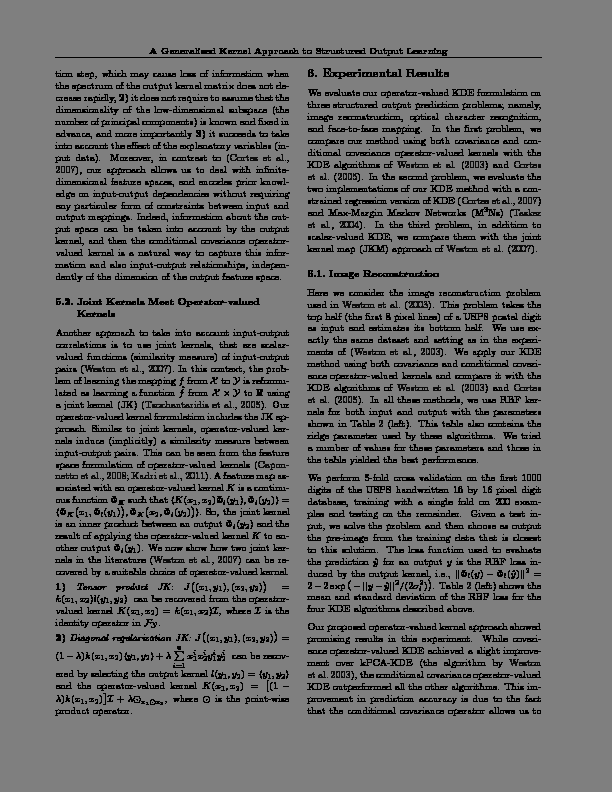

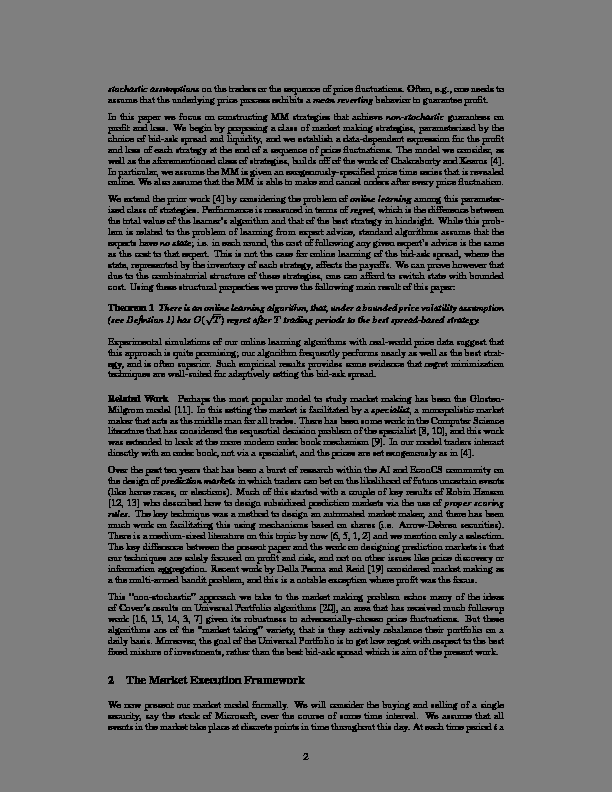

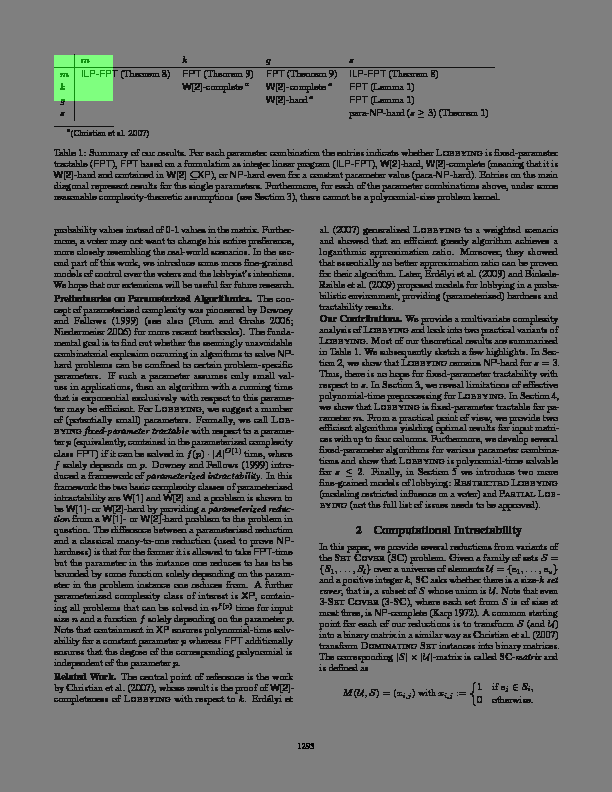

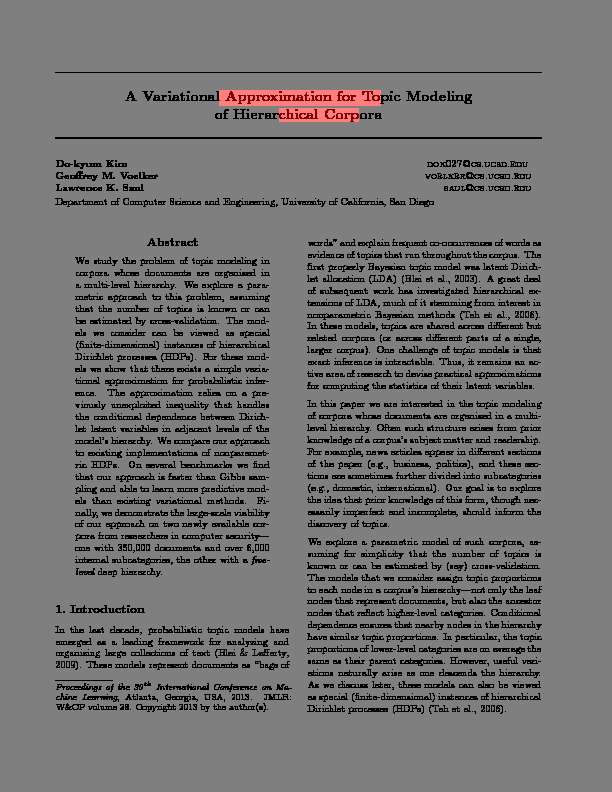

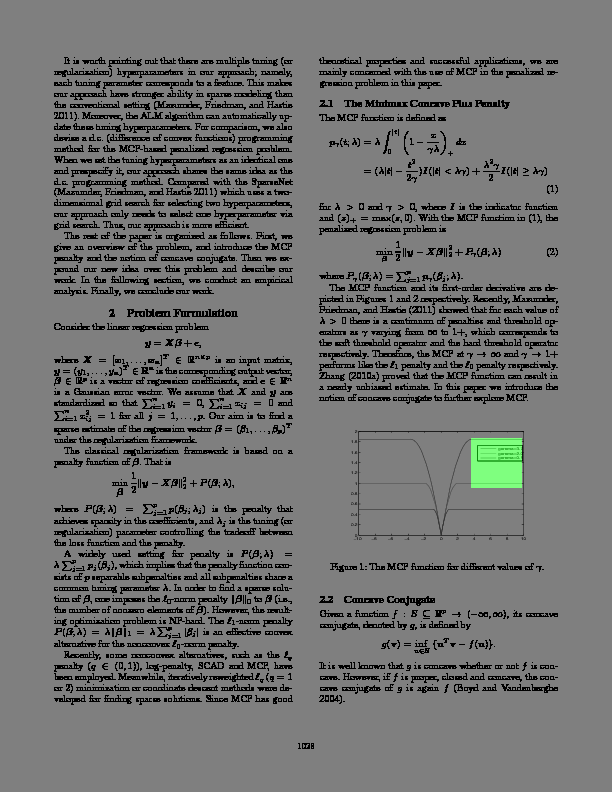

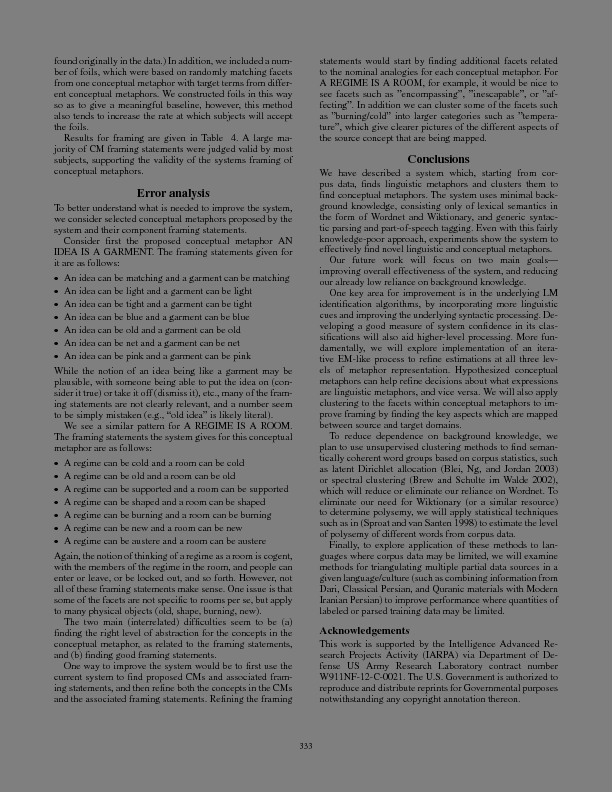

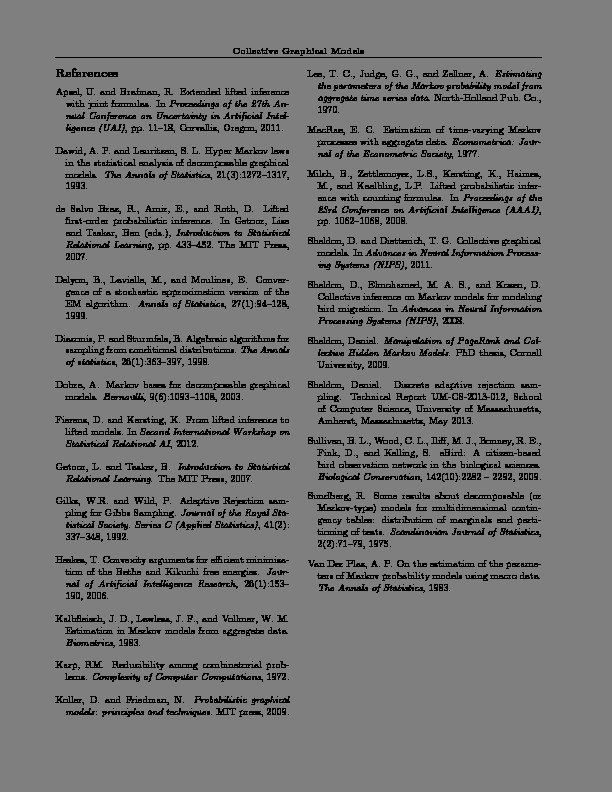

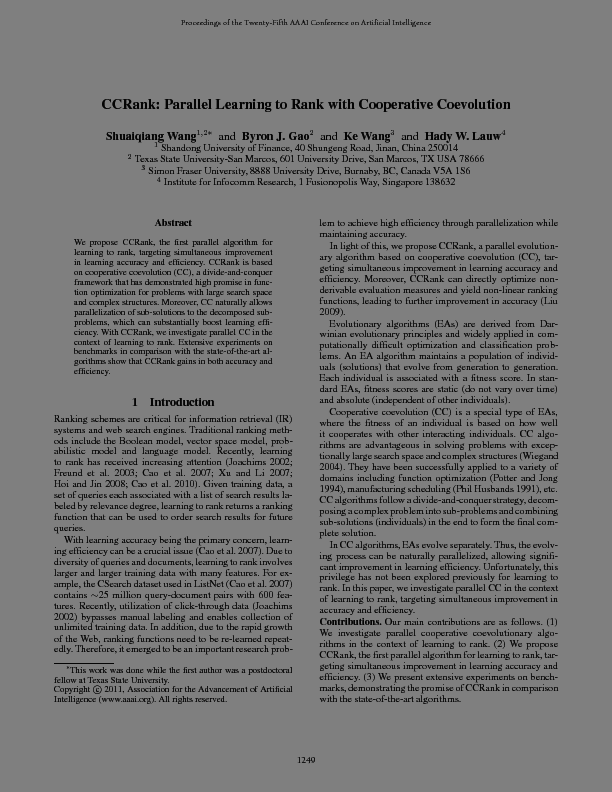

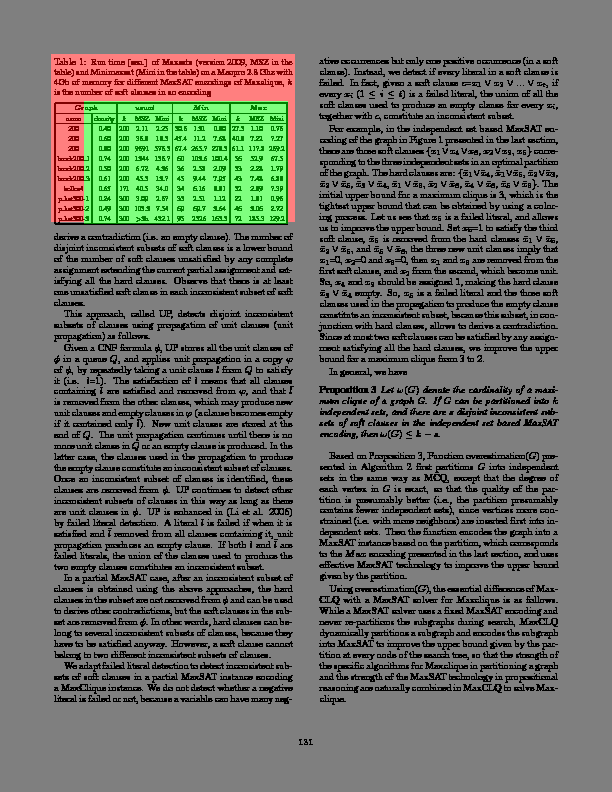

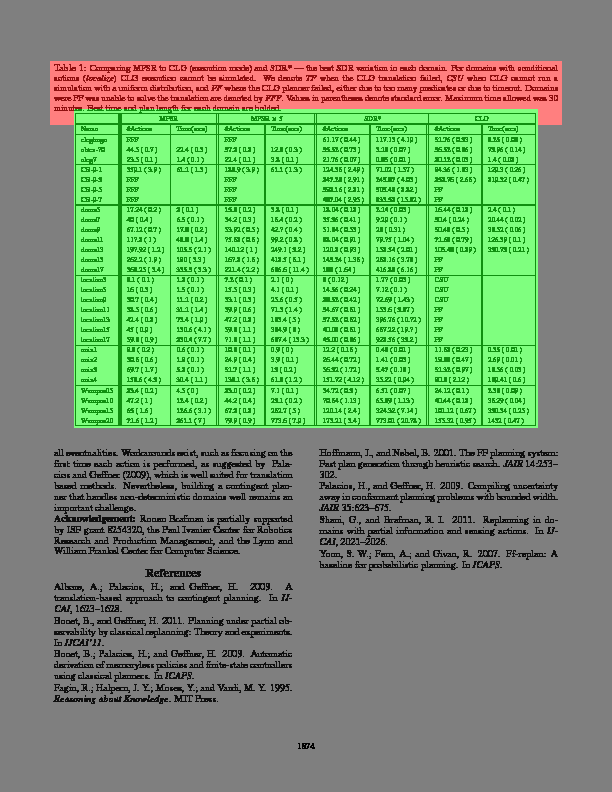

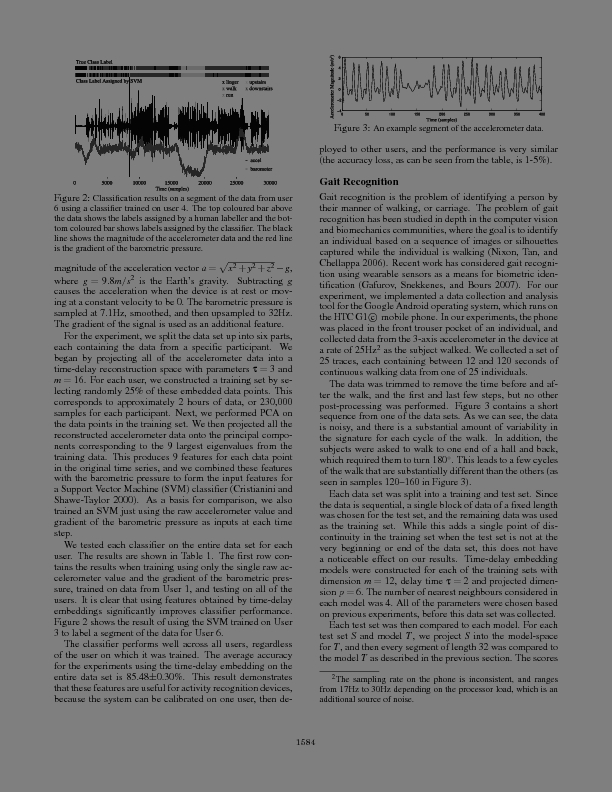

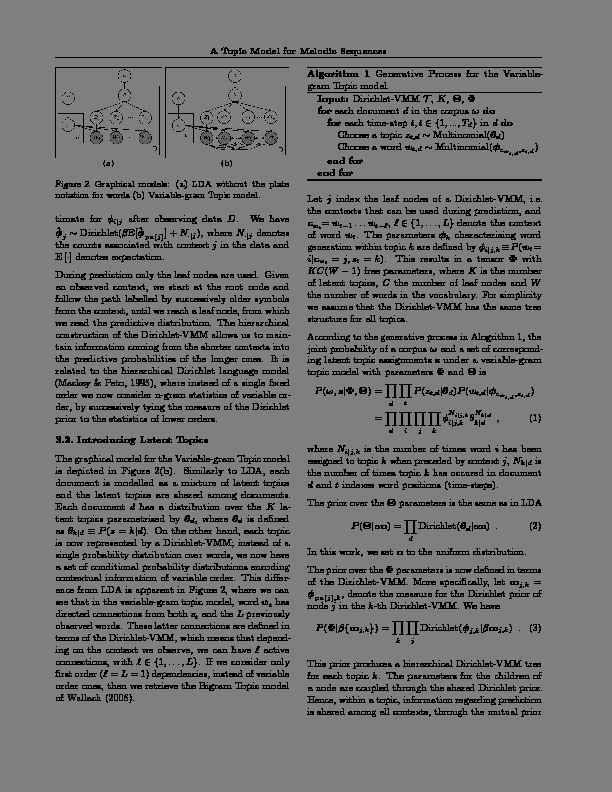

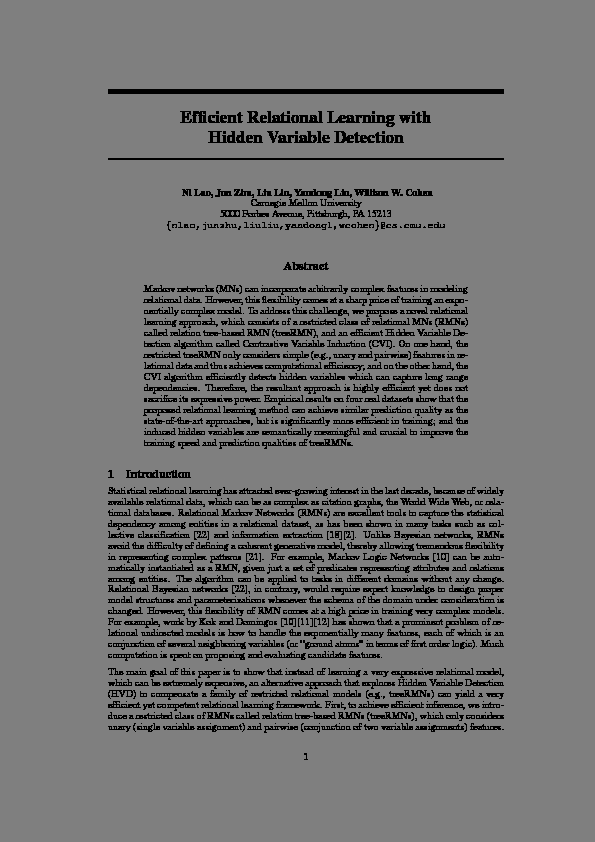

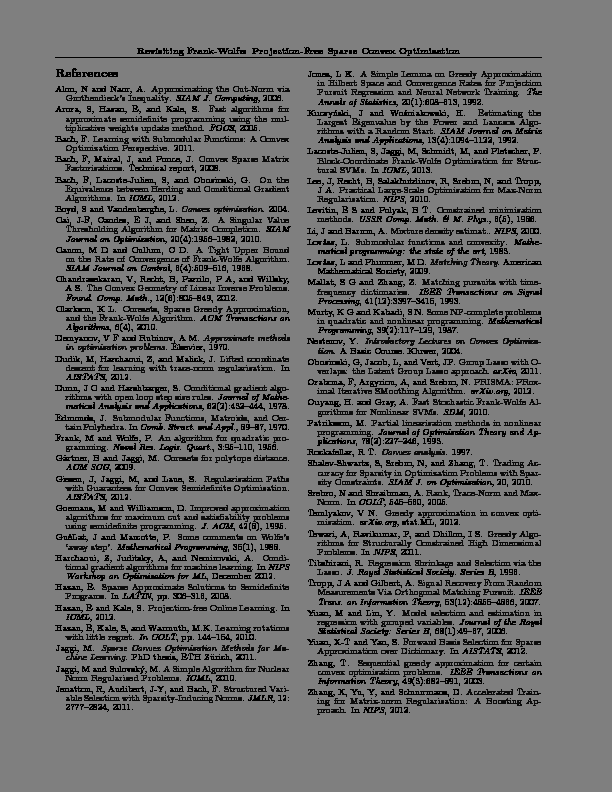

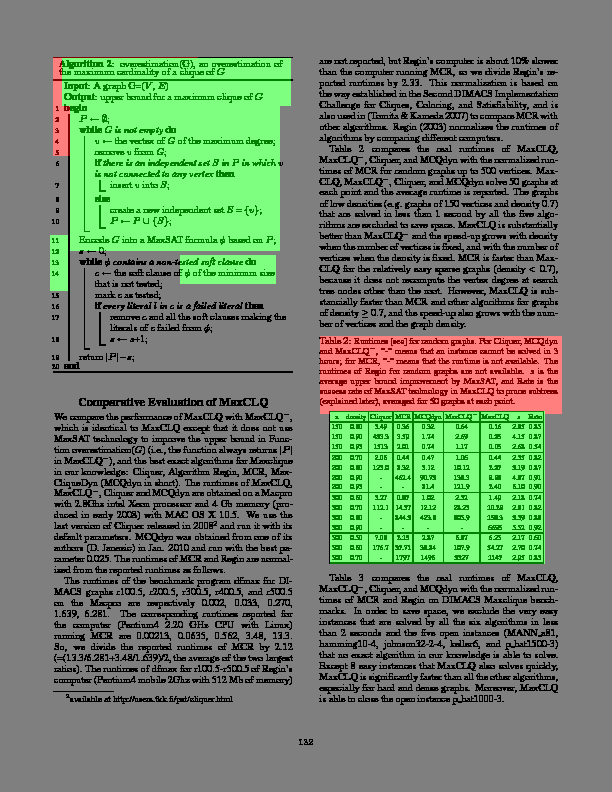

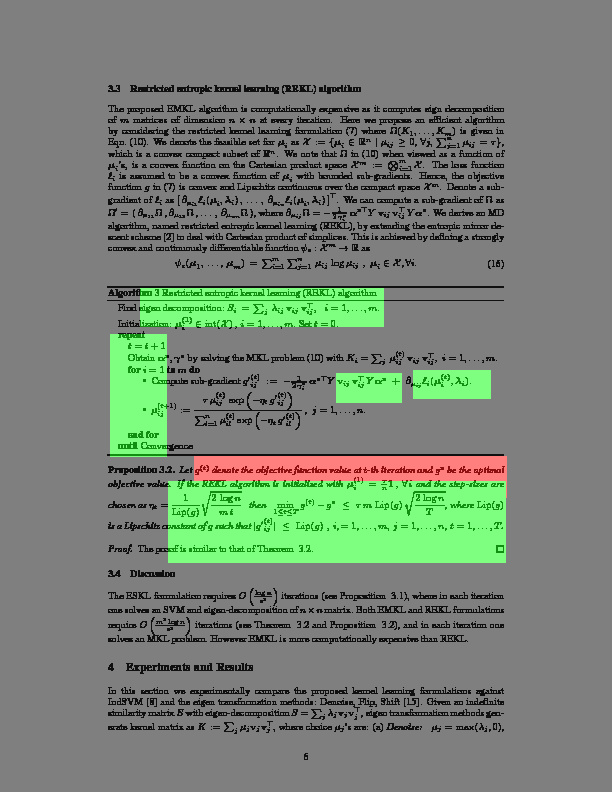

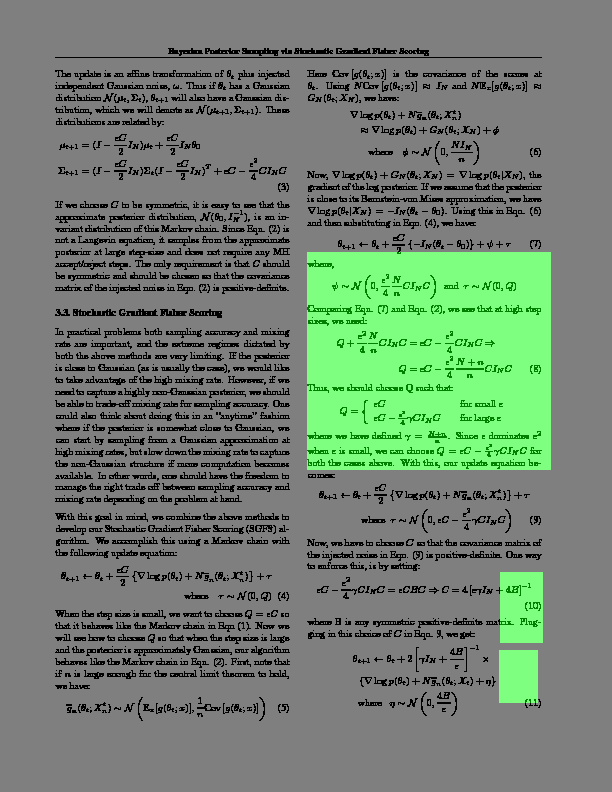

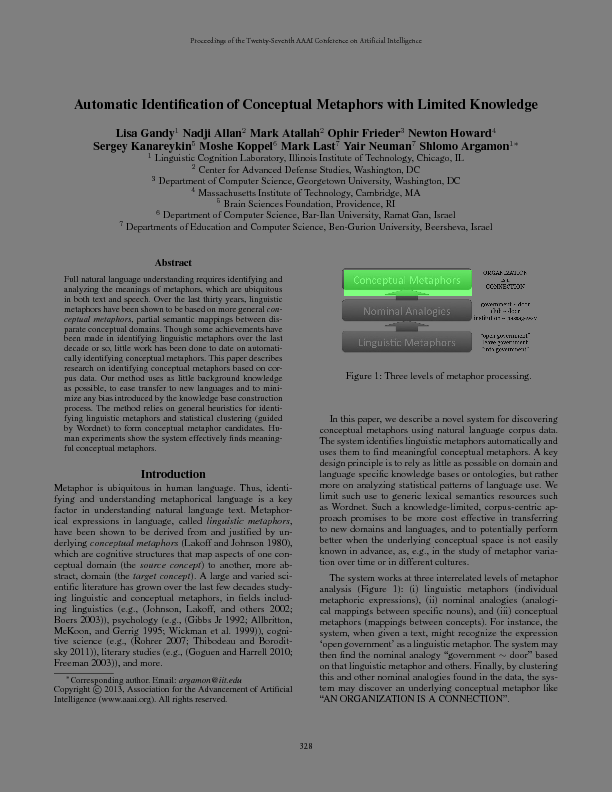

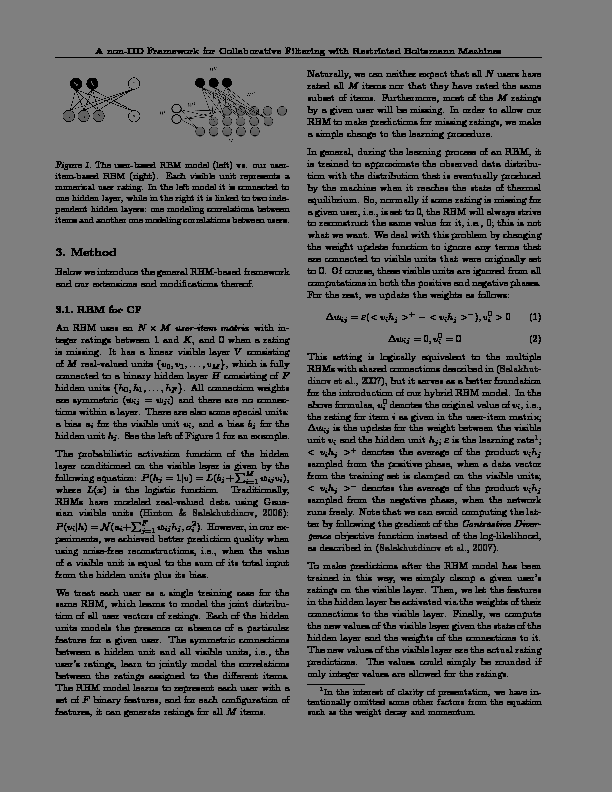

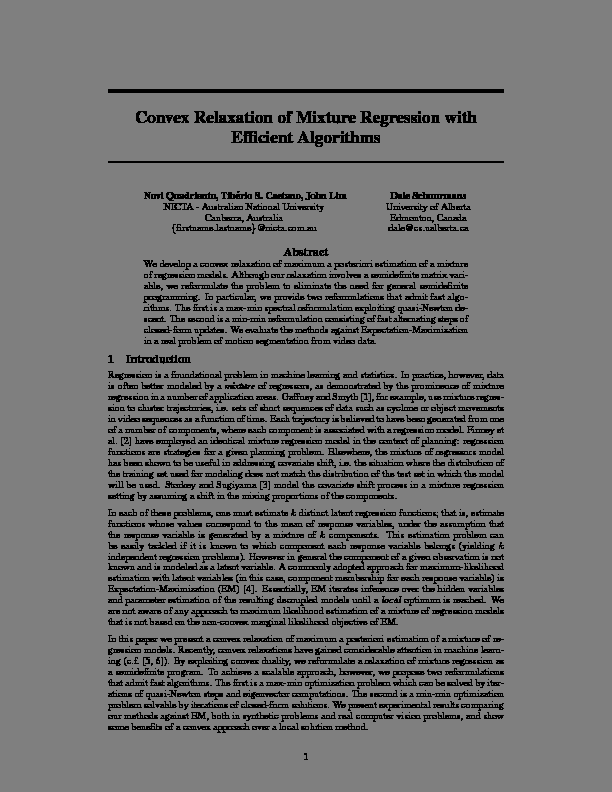

mean       std
macro surrounding_text gold_n     0.666667  0.516398
                       found_n    0.833333  1.602082
                       f1         0.233333  0.408248
                       prec       0.208333  0.400520
                       rec        0.333333  0.516398
                       fp         0.125000  0.306186
                       tp         0.208333  0.400520
                       fn         0.333333  0.516398
                       full_dice  0.065484  0.102478
                       tp_dice    0.152247  0.279583
      body             gold_n     0.666667  0.516398
                       found_n    1.500000  0.836660
                       f1         0.444444  0.501848
                       prec       0.416667  0.491596
                       rec        0.500000  0.547723
                       fp         0.583333  0.491596
                       tp         0.416667  0.491596
                       fn         0.166667  0.408248
                       full_dice  0.412880  0.443159
                       tp_dice    0.464098  0.510009
micro surrounding_text gold_n     3.400000  2.118700
                       found_n    3.600000  2.503331
                       f1         0.553935  0.296158
                       prec       0.547500  0.348897
                       rec        0.623969  0.336987
                       fp         0.352500  0.316327
                       tp         0.547500  0.348897
                       fn         0.383333  0.330572
                       full_dice  0.175890  0.064312
                       tp_dice    0.349353  0.194061
      body             gold_n     3.400000  2.118700
                       found_n    7.300000  4.029061
                       f1         0.509852  0.219189
                       prec       0.401515  0.202438
                       rec        0.797689  0.297804
                       fp         0.598485  0.202438
                       tp         0.401515  0.202438
                       fn         0.157143  0.254328
                       full_dice  0.389217  0.180099
                       tp_dice    0.916280  0.034531

In [14]:
segmentation_model = load_model('/notebook/models/full_model', custom_objects=model.__dict__)
nn_tabula_pf2_eval_result = calc_metrics_per_dir('/notebook/pdffigures2/evaluation/datasets/conference/page_images_color_only_with_tables/',
                                                 make_pdffigures2_gold_rects_getter('/notebook/pdffigures2/evaluation/datasets/conference/annotations.json'),
                                                 make_nn_tabula_rect_getter(segmentation_model,
                                                                            '/notebook/pdffigures2/evaluation/datasets/conference/pdfs/',
                                                                            page_no_one_based=True),
                                                 min_tp_dice=0.2,
                                                 extension='jpg')
nn_tabula_pf2_eval_result.transpose()[['mean', 'std']]

### S2 dataset

In [ ]:
# segmentation_model = load_model('/notebook/models/full_model', custom_objects=model.__dict__)
# nn_tabula_pf2_eval_result = calc_metrics_per_dir('/notebook/pdffigures2/evaluation/datasets/s2/page_images_color/',
#                                                  make_pdffigures2_gold_rects_getter('/notebook/pdffigures2/evaluation/datasets/s2/annotations.json'),
#                                                  make_nn_tabula_rect_getter(segmentation_model,
#                                                                             '/notebook/pdffigures2/evaluation/s2/conference/pdfs/',
#                                                                             page_no_one_based=True),
#                                                  extension='jpg')
# nn_tabula_pf2_eval_result.transpose()[['mean', 'std']]

## Their dataset, their pipeline